# All Models evaluation and comparison

In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
distilbert_df = pd.read_csv("distilbert_predictions.csv")  # already contains DistilBERT_Pred
mistral_df = pd.read_csv("predicted_reviews.csv")          # contains Mistral_Predicted_Rating
textblob_df = pd.read_csv("sampled_glassdoor_reviews_with_textblob.csv")                          # already in memory

distilbert_df = distilbert_df.rename(columns={
    'Review': 'Review_Clean',
    'True_Label': 'True_Label',
    'Predicted_Label': 'DistilBERT'
})

# Rename columns in mistral_df
mistral_df = mistral_df.rename(columns={
    'Overall Rating': 'True_Label',
    'Mistral_Predicted_Rating': 'Mistral'
})

# Rename columns in textblob_df
textblob_df = textblob_df.rename(columns={
    'Overall Rating': 'True_Label',
    'TextBlob_Rating': 'TextBlob'
})




In [4]:
print(list(textblob_df.columns))


['Company', 'Date Posted', 'Job Title', 'Location', 'True_Label', 'Work/Life Balance', 'Company Culture', 'Diversity Inclusion', 'Career Opportunity', 'Company Benefits', 'Management', 'Post Title', 'Pros', 'Cons', 'pros_length', 'cons_length', 'Review_Combined', 'Review_Clean', 'TextBlob_Score', 'TextBlob']


In [ ]:


#  Merge all three datasets on Review_Clean and True_Label
df_combined = distilbert_df[['Review_Clean', 'True_Label', 'DistilBERT']] \
    .merge(mistral_df[['Review_Clean', 'True_Label', 'Mistral']], on=['Review_Clean', 'True_Label'], how='inner') \
    .merge(textblob_df[['Review_Clean', 'True_Label', 'TextBlob']], on=['Review_Clean', 'True_Label'], how='inner')



df_combined.head()

,Review_Clean,True_Label,DistilBERT,Mistral,TextBlob
0,good pay time job short break tireless hour,3,4,4.0,4
1,people culture compensation hours kpi work ana...,5,4,NaN,2
2,opportunity grow constant feedback tiring job,4,3,3.0,2
3,job opportunity world internal training techno...,5,4,3.0,4
4,great team member facility extremely high pres...,4,5,4.0,5


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Drop rows with any missing model predictions (especially Mistral which has NaNs)
df_valid = df_combined.dropna(subset=['DistilBERT', 'Mistral', 'TextBlob'])

# Convert all predictions to integers
df_valid['Mistral'] = df_valid['Mistral'].astype(int)
df_valid['TextBlob'] = df_valid['TextBlob'].astype(int)

# Evaluate all three models
models = ['DistilBERT', 'Mistral', 'TextBlob']
metrics = []

for model in models:
    y_true = df_valid['True_Label']
    y_pred = df_valid[model]
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics.append({
        'Model': model,
        'Accuracy': report['accuracy'],
        'Precision': report['macro avg']['precision'],
        'Recall': report['macro avg']['recall'],
        'F1': report['macro avg']['f1-score']
    })

# Create a summary DataFrame
metrics_df = pd.DataFrame(metrics).set_index('Model')


metrics_df.style.background_gradient(cmap="Blues").format("{:.3f}")

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80876/3951483739.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Mistral'] = df_valid['Mistral'].astype(int)
/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80876/3951483739.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['TextBlob'] = df_valid['TextBlob'].astype(int)
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is

,Accuracy,Precision,Recall,F1
Model,,,,
DistilBERT,0.442,0.398,0.374,0.372
Mistral,0.406,0.394,0.359,0.342
TextBlob,0.306,0.295,0.299,0.288


<Figure size 1000x600 with 0 Axes>

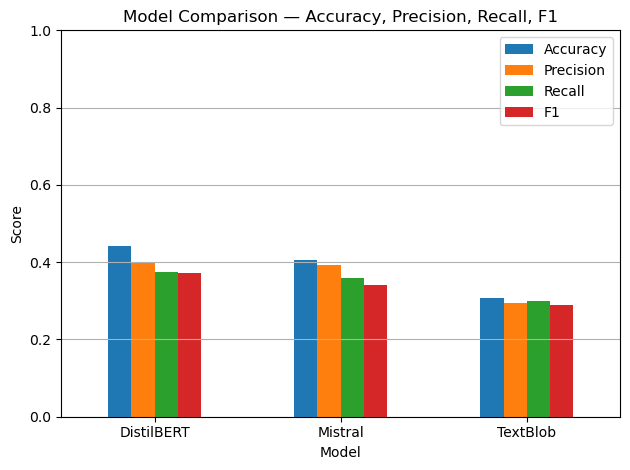

In [ ]:
# Visualize the results

# Bar Chart of Accuracy, Precision, Recall, F1
plt.figure(figsize=(10, 6))
metrics_df.plot(kind="bar")
plt.title("Model Comparison — Accuracy, Precision, Recall, F1")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

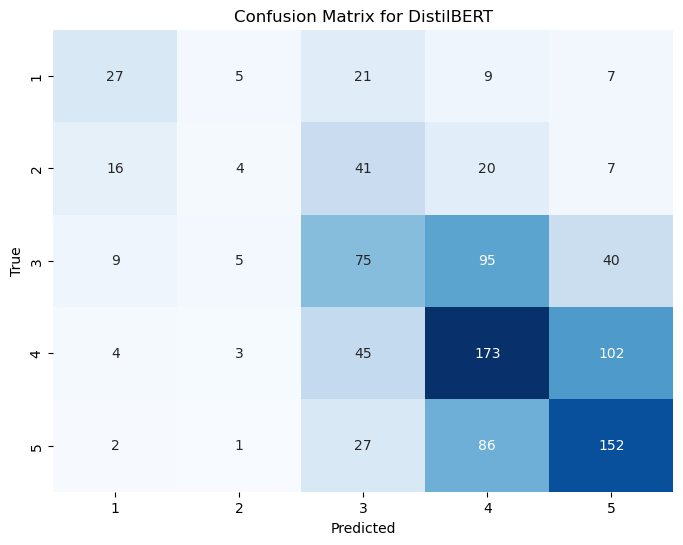

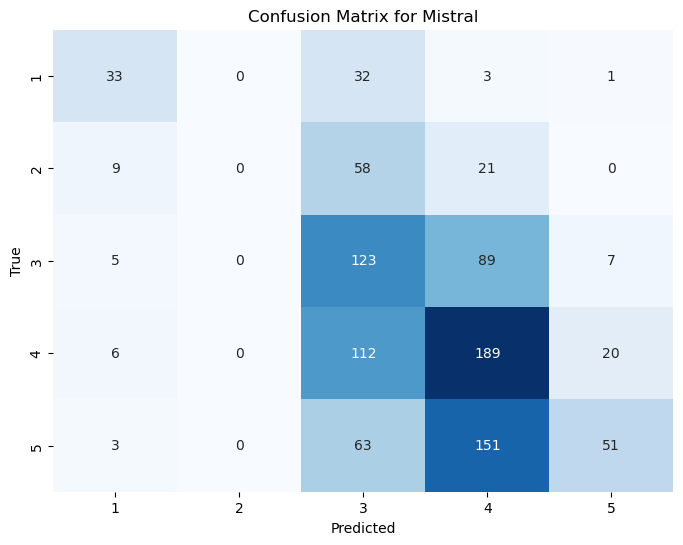

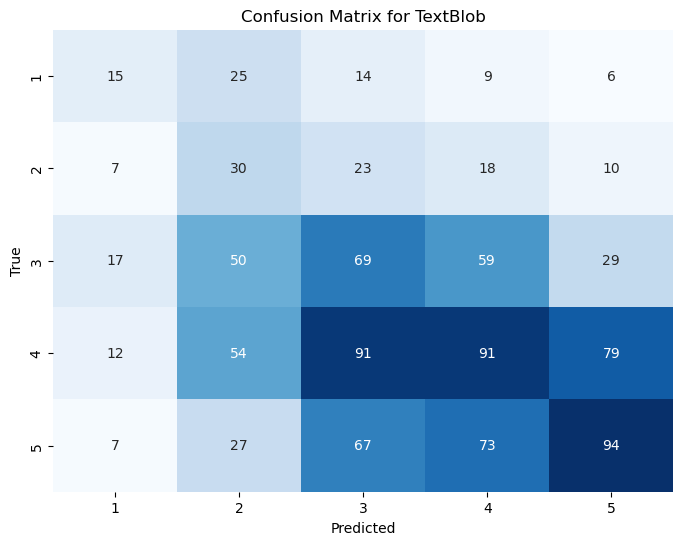

In [8]:
# Confusion Matrix for each model
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['1', '2', '3', '4', '5'],
                yticklabels=['1', '2', '3', '4', '5'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for each model
for model in models:
    y_true = df_valid['True_Label']
    y_pred = df_valid[model]
    plot_confusion_matrix(y_true, y_pred, model)


In [ ]:
df_combined.to_csv("combined_predictions.csv", index=False)
metrics_df.to_csv("model_metrics.csv")

In [ ]:
# filter rows where at least one model predicted differently than the true label
df_errors = df_valid[
    (df_valid['DistilBERT'] != df_valid['True_Label']) |
    (df_valid['Mistral'] != df_valid['True_Label']) |
    (df_valid['TextBlob'] != df_valid['True_Label'])
]

# Randomly sample 10 such contradicting cases for review
sample_misclassified = df_errors.sample(10, random_state=42)

# Show relevant columns
comparison_table = sample_misclassified[[
    'Review_Clean', 'True_Label', 'DistilBERT', 'Mistral', 'TextBlob'
]]

# Misclassified reviews
# Display the sampled misclassified reviews
comparison_table.reset_index(drop=True, inplace=True)
print(comparison_table.to_string(index=False))

comparison_table.to_csv("misclassified_reviews.csv", index=False)
    

                                                                                                                                                                                                                                                             Review_Clean  True_Label  DistilBERT  Mistral  TextBlob
                                                                                                                  good salary improvement work life balance year manager europe asia office think feudal lord manager relocate asia team opinion local know  culture suck           2           3        3         4
company wise good benefit discount support hr personal issue etc company good poor management team branch make brand look extremely bad work previous branch experience appalling treatment staff especially new starter like use disgusting branch make company look bad           4           1        1         2
                                                                         

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80876/3661355858.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=model_name, data=df, palette="Set2")


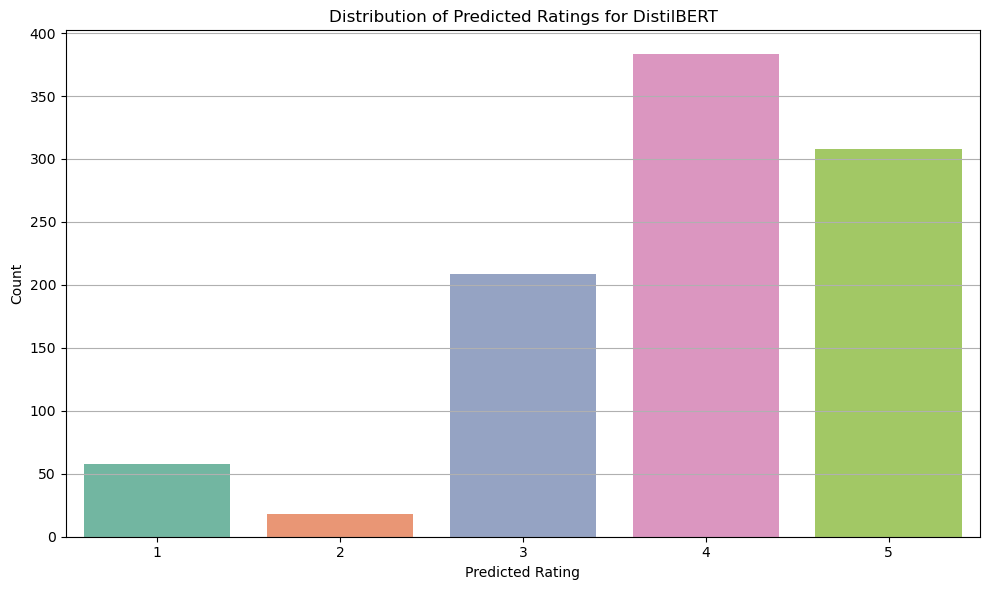

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80876/3661355858.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=model_name, data=df, palette="Set2")


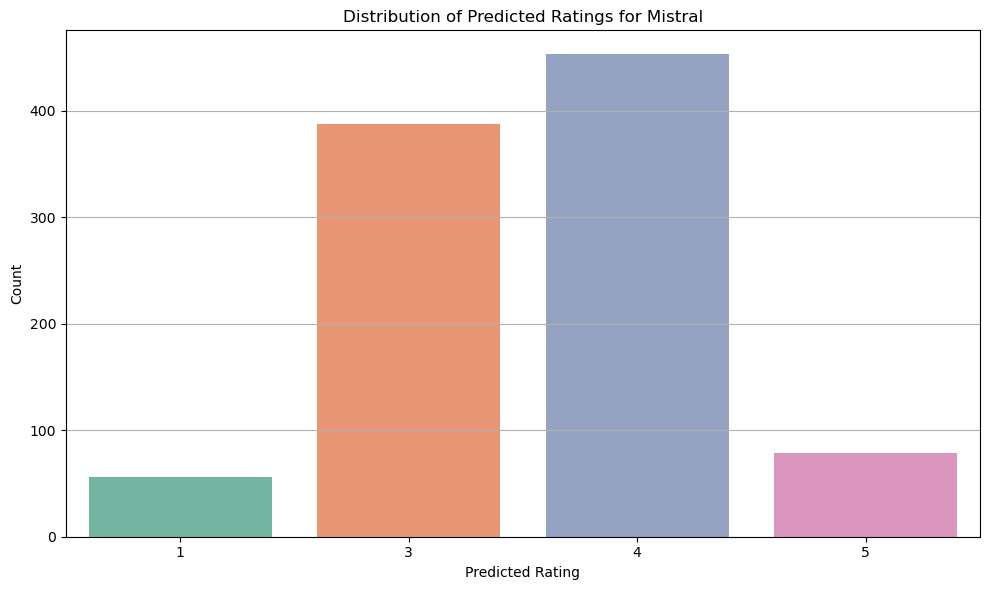

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80876/3661355858.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=model_name, data=df, palette="Set2")


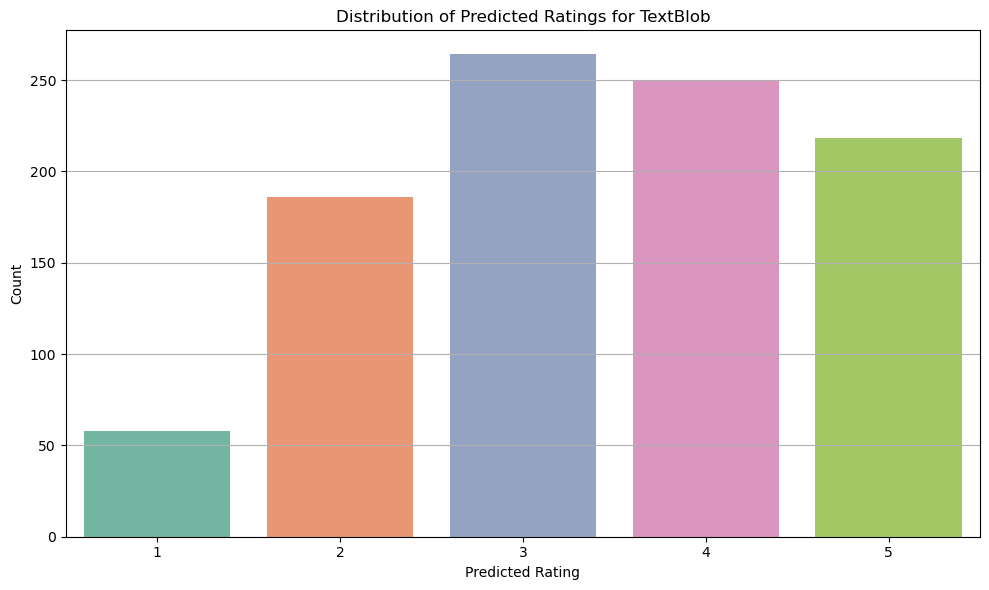

In [11]:
# distribution of predicted ratings for each model
def plot_rating_distribution(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=model_name, data=df, palette="Set2")
    plt.title(f'Distribution of Predicted Ratings for {model_name}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# Plot rating distributions for each model
for model in models:
    plot_rating_distribution(df_valid, model)


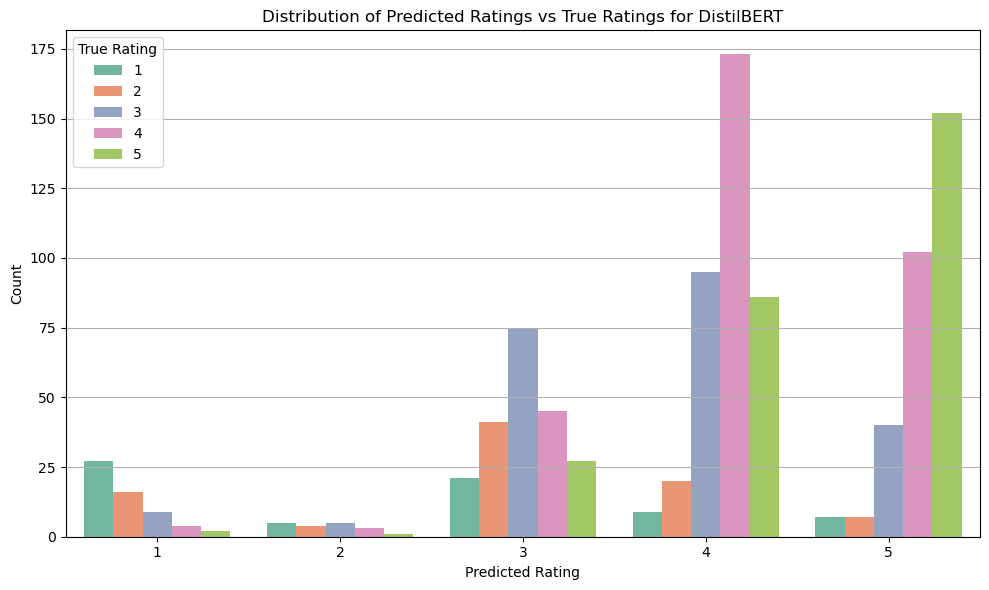

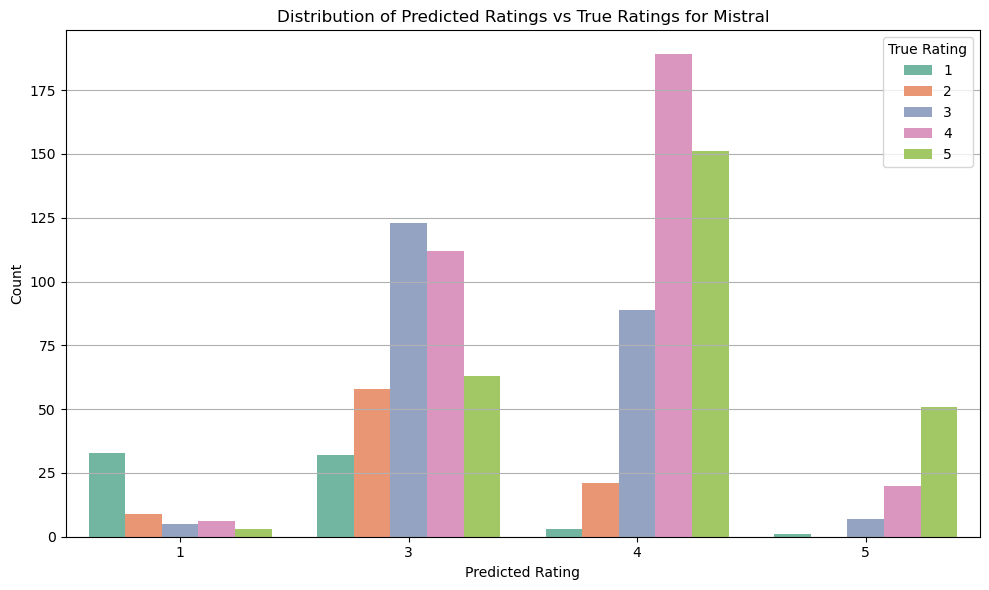

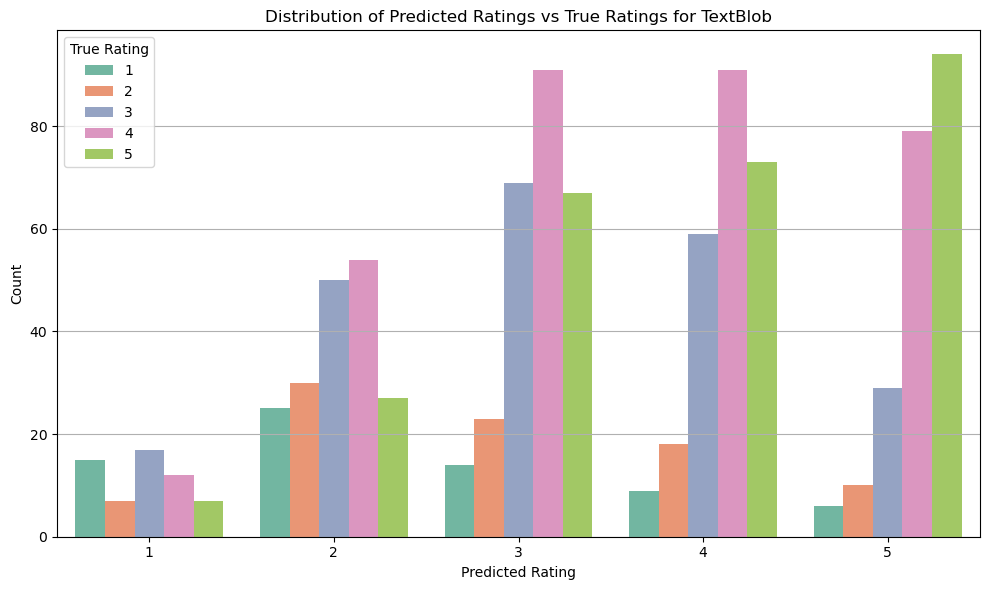

In [ ]:
#distribution of predicted ratings vs overall rating for each model


def plot_rating_distribution_vs_true(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=model_name, hue='True_Label', data=df, palette="Set2")
    plt.title(f'Distribution of Predicted Ratings vs True Ratings for {model_name}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title='True Rating')
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# Plot rating distributions against true ratings for each model
for model in models:
    plot_rating_distribution_vs_true(df_valid, model)



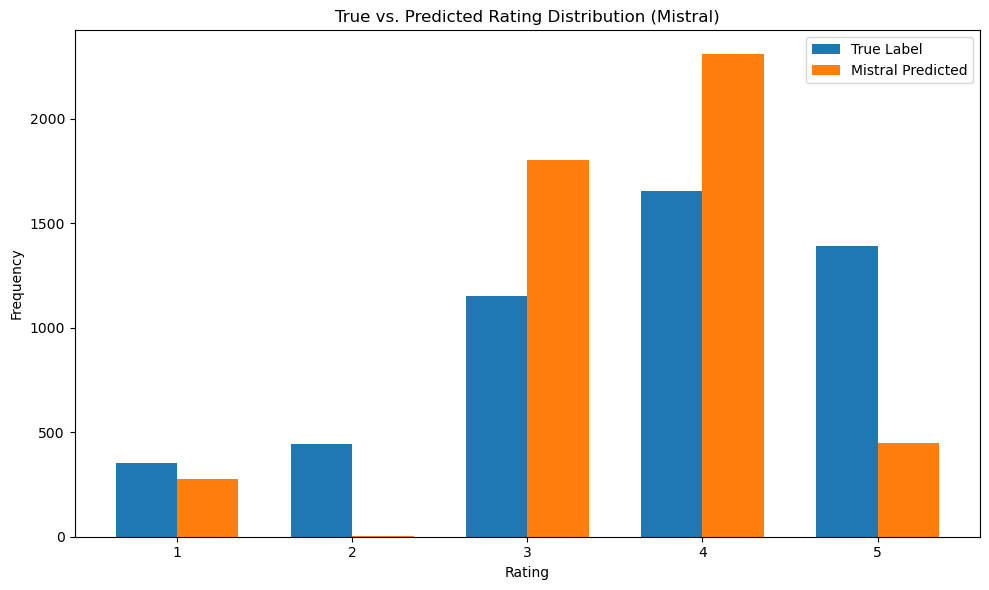

In [ ]:
# Mistral specific - plot the distribution of true vs predicted ratings
# TextBlob can be found in sentimentmodels.ipynb
# DistilBert can be found in distilbert_model.ipynb 

import numpy as np
labels      = sorted(mistral_df['True_Label'].unique())
true_counts = mistral_df['True_Label'].value_counts().reindex(labels, fill_value=0)
pred_counts = mistral_df['Mistral'].value_counts().reindex(labels, fill_value=0)

x     = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, true_counts,  width, label='True Label')
ax.bar(x + width/2, pred_counts,  width, label='Mistral Predicted')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('True vs. Predicted Rating Distribution (Mistral)')
ax.legend()
plt.tight_layout()
plt.show()